# Comprehensive Multilingual QA Model Comparison

This notebook provides a comprehensive comparison of transformer models across English and Arabic question answering tasks, analyzing performance, efficiency, and language-specific characteristics.

## Setup and Imports

In [2]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import json
import time
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

# Import our utilities
from models.model_handler import ModelHandler
from utils.evaluation import QAEvaluator
from utils.data_loader import DataLoader
from utils.language_detector import LanguageDetector

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

print("Multilingual QA Model Comparison Framework Initialized")
print("=" * 60)

Multilingual QA Model Comparison Framework Initialized


## Model Definitions and Configuration

In [3]:
# Initialize components
model_handler = ModelHandler()
evaluator = QAEvaluator()
data_loader = DataLoader()
language_detector = LanguageDetector()

# Define comprehensive model comparison
models_config = {
    # English-specific models
    'BERT-Large': {
        'model_id': 'bert-large-uncased-whole-word-masking-finetuned-squad',
        'language': 'English',
        'type': 'BERT',
        'size': 'Large',
        'parameters': '340M'
    },
    'DistilBERT': {
        'model_id': 'distilbert-base-cased-distilled-squad',
        'language': 'English',
        'type': 'DistilBERT',
        'size': 'Base',
        'parameters': '66M'
    },
    'RoBERTa': {
        'model_id': 'deepset/roberta-base-squad2',
        'language': 'English',
        'type': 'RoBERTa',
        'size': 'Base',
        'parameters': '125M'
    },
    'ALBERT': {
        'model_id': 'twmkn9/albert-base-v2-squad2',
        'language': 'English',
        'type': 'ALBERT',
        'size': 'Base',
        'parameters': '12M'
    },
    
    # Multilingual models
    'mBERT': {
        'model_id': 'bert-base-multilingual-cased',
        'language': 'Multilingual',
        'type': 'BERT',
        'size': 'Base',
        'parameters': '179M'
    },
    'XLM-RoBERTa': {
        'model_id': 'deepset/xlm-roberta-base-squad2',
        'language': 'Multilingual',
        'type': 'XLM-RoBERTa',
        'size': 'Base',
        'parameters': '278M'
    },
    
    # Arabic-specific models
    'AraBERT': {
        'model_id': 'aubmindlab/bert-base-arabertv2-finetuned-squadv1',
        'language': 'Arabic',
        'type': 'AraBERT',
        'size': 'Base',
        'parameters': '136M'
    }
}

print(f"Configured {len(models_config)} models for comparison:")
for name, config in models_config.items():
    print(f"  {name:15} | {config['language']:12} | {config['type']:12} | {config['parameters']:8}")

Configured 7 models for comparison:
  BERT-Large      | English      | BERT         | 340M    
  DistilBERT      | English      | DistilBERT   | 66M     
  RoBERTa         | English      | RoBERTa      | 125M    
  ALBERT          | English      | ALBERT       | 12M     
  mBERT           | Multilingual | BERT         | 179M    
  XLM-RoBERTa     | Multilingual | XLM-RoBERTa  | 278M    
  AraBERT         | Arabic       | AraBERT      | 136M    


## Test Dataset Preparation

In [4]:
# Prepare multilingual test datasets
english_test_data = [
    {
        'context': 'The Amazon rainforest, also known as Amazonia, is a moist broadleaf tropical rainforest in the Amazon biome that covers most of the Amazon basin of South America. This basin encompasses 7,000,000 km2 (2,700,000 sq mi), of which 5,500,000 km2 (2,100,000 sq mi) are covered by the rainforest.',
        'question': 'How much area does the Amazon basin cover?',
        'answer': '7,000,000 km2',
        'language': 'English'
    },
    {
        'context': 'Artificial intelligence (AI) is intelligence demonstrated by machines, in contrast to the natural intelligence displayed by humans and animals. Leading AI textbooks define the field as the study of "intelligent agents": any device that perceives its environment and takes actions that maximize its chance of successfully achieving its goals.',
        'question': 'What is artificial intelligence?',
        'answer': 'intelligence demonstrated by machines',
        'language': 'English'
    },
    {
        'context': 'The Great Wall of China is a series of fortifications made of stone, brick, tamped earth, wood, and other materials, generally built along an east-to-west line across the historical northern borders of China to protect the Chinese states and empires against the raids and invasions of the various nomadic groups.',
        'question': 'What materials was the Great Wall of China made of?',
        'answer': 'stone, brick, tamped earth, wood, and other materials',
        'language': 'English'
    }
]

arabic_test_data = [
    {
        'context': 'القاهرة هي عاصمة جمهورية مصر العربية وأكبر مدنها. تقع على ضفاف نهر النيل في شمال مصر، وهي واحدة من أكبر المدن في أفريقيا والشرق الأوسط. يبلغ عدد سكان القاهرة الكبرى حوالي 20 مليون نسمة.',
        'question': 'ما هي عاصمة مصر؟',
        'answer': 'القاهرة',
        'language': 'Arabic'
    },
    {
        'context': 'الذكاء الاصطناعي هو محاكاة عمليات الذكاء البشري بواسطة الآلات، وخاصة أنظمة الحاسوب. تشمل هذه العمليات التعلم واكتساب المعلومات وقواعد استخدام المعلومات والتفكير المنطقي والتصحيح الذاتي.',
        'question': 'ما هو الذكاء الاصطناعي؟',
        'answer': 'محاكاة عمليات الذكاء البشري بواسطة الآلات',
        'language': 'Arabic'
    },
    {
        'context': 'كرة القدم هي رياضة جماعية تلعب بين فريقين، يتكون كل منهما من أحد عشر لاعباً. تمارس من قبل 250 مليون لاعب في أكثر من مائتي دولة ومنطقة حول العالم، مما يجعلها الرياضة الأكثر شعبية في العالم.',
        'question': 'كم عدد اللاعبين في فريق كرة القدم؟',
        'answer': 'أحد عشر لاعباً',
        'language': 'Arabic'
    }
]

# Combine test datasets
all_test_data = english_test_data + arabic_test_data

print(f"Test dataset prepared:")
print(f"  English examples: {len(english_test_data)}")
print(f"  Arabic examples: {len(arabic_test_data)}")
print(f"  Total examples: {len(all_test_data)}")

Test dataset prepared:
  English examples: 3
  Arabic examples: 3
  Total examples: 6


## Comprehensive Model Evaluation

In [5]:
# Run comprehensive evaluation
print("Starting comprehensive model evaluation...")
print("=" * 50)

evaluation_results = {}
detailed_results = []

for model_name, model_config in models_config.items():
    print(f"\nEvaluating {model_name} ({model_config['language']})...")
    
    model_results = {
        'model_name': model_name,
        'model_config': model_config,
        'english_results': {'predictions': [], 'metrics': {}},
        'arabic_results': {'predictions': [], 'metrics': {}},
        'overall_results': {'predictions': [], 'metrics': {}}
    }
    
    # Test on all data
    all_predictions = []
    all_ground_truths = []
    all_confidences = []
    all_inference_times = []
    
    for example in tqdm(all_test_data, desc=f"{model_name}"):
        context = example['context']
        question = example['question']
        ground_truth = example['answer']
        lang = example['language']
        
        # Measure inference time
        start_time = time.time()
        
        try:
            result = model_handler.get_answer(context, question, model_config['model_id'])
            prediction = result['answer']
            confidence = result['score']
        except Exception as e:
            print(f"    Error with {model_name}: {e}")
            prediction = ""
            confidence = 0.0
        
        inference_time = time.time() - start_time
        
        # Calculate metrics
        exact_match = evaluator.exact_match_score(prediction, ground_truth)
        f1_score = evaluator.f1_score(prediction, ground_truth)
        
        # Store detailed result
        detailed_result = {
            'model_name': model_name,
            'model_type': model_config['type'],
            'model_language': model_config['language'],
            'question_language': lang,
            'question': question,
            'context': context[:100] + "..." if len(context) > 100 else context,
            'ground_truth': ground_truth,
            'prediction': prediction,
            'confidence': confidence,
            'exact_match': exact_match,
            'f1_score': f1_score,
            'inference_time': inference_time
        }
        detailed_results.append(detailed_result)
        
        # Aggregate for overall metrics
        all_predictions.append(prediction)
        all_ground_truths.append(ground_truth)
        all_confidences.append(confidence)
        all_inference_times.append(inference_time)
        
        # Separate by language
        if lang == 'English':
            model_results['english_results']['predictions'].append({
                'prediction': prediction, 'ground_truth': ground_truth,
                'confidence': confidence, 'exact_match': exact_match,
                'f1_score': f1_score, 'inference_time': inference_time
            })
        elif lang == 'Arabic':
            model_results['arabic_results']['predictions'].append({
                'prediction': prediction, 'ground_truth': ground_truth,
                'confidence': confidence, 'exact_match': exact_match,
                'f1_score': f1_score, 'inference_time': inference_time
            })
    
    # Calculate overall metrics
    overall_metrics = evaluator.evaluate_predictions(all_predictions, all_ground_truths)
    model_results['overall_results']['metrics'] = {
        'exact_match': overall_metrics['exact_match'],
        'f1_score': overall_metrics['f1_score'],
        'avg_confidence': np.mean(all_confidences),
        'avg_inference_time': np.mean(all_inference_times),
        'total_examples': len(all_predictions)
    }
    
    # Calculate language-specific metrics
    if model_results['english_results']['predictions']:
        en_preds = [p['prediction'] for p in model_results['english_results']['predictions']]
        en_gts = [p['ground_truth'] for p in model_results['english_results']['predictions']]
        en_metrics = evaluator.evaluate_predictions(en_preds, en_gts)
        model_results['english_results']['metrics'] = {
            'exact_match': en_metrics['exact_match'],
            'f1_score': en_metrics['f1_score'],
            'avg_confidence': np.mean([p['confidence'] for p in model_results['english_results']['predictions']]),
            'avg_inference_time': np.mean([p['inference_time'] for p in model_results['english_results']['predictions']])
        }
    
    if model_results['arabic_results']['predictions']:
        ar_preds = [p['prediction'] for p in model_results['arabic_results']['predictions']]
        ar_gts = [p['ground_truth'] for p in model_results['arabic_results']['predictions']]
        ar_metrics = evaluator.evaluate_predictions(ar_preds, ar_gts)
        model_results['arabic_results']['metrics'] = {
            'exact_match': ar_metrics['exact_match'],
            'f1_score': ar_metrics['f1_score'],
            'avg_confidence': np.mean([p['confidence'] for p in model_results['arabic_results']['predictions']]),
            'avg_inference_time': np.mean([p['inference_time'] for p in model_results['arabic_results']['predictions']])
        }
    
    evaluation_results[model_name] = model_results
    
    # Print summary
    print(f"    Overall EM: {overall_metrics['exact_match']:.3f}, F1: {overall_metrics['f1_score']:.3f}")
    print(f"    Avg Confidence: {np.mean(all_confidences):.3f}, Avg Time: {np.mean(all_inference_times):.3f}s")

print("\nEvaluation completed!")

Starting comprehensive model evaluation...

Evaluating BERT-Large (English)...


BERT-Large:   0%|          | 0/6 [00:00<?, ?it/s]INFO:models.model_handler:Loading model: bert-large-uncased-whole-word-masking-finetuned-squad
INFO:models.model_handler:Successfully loaded model: bert-large-uncased-whole-word-masking-finetuned-squad
BERT-Large: 100%|██████████| 6/6 [00:06<00:00,  1.10s/it]


    Overall EM: 0.500, F1: 0.621
    Avg Confidence: 0.425, Avg Time: 1.103s

Evaluating DistilBERT (English)...


DistilBERT:   0%|          | 0/6 [00:00<?, ?it/s]INFO:models.model_handler:Loading model: distilbert-base-cased-distilled-squad
INFO:models.model_handler:Successfully loaded model: distilbert-base-cased-distilled-squad
DistilBERT: 100%|██████████| 6/6 [00:01<00:00,  3.07it/s]


    Overall EM: 0.000, F1: 0.376
    Avg Confidence: 0.217, Avg Time: 0.326s

Evaluating RoBERTa (English)...


RoBERTa:   0%|          | 0/6 [00:00<?, ?it/s]INFO:models.model_handler:Loading model: deepset/roberta-base-squad2
INFO:models.model_handler:Successfully loaded model: deepset/roberta-base-squad2
RoBERTa: 100%|██████████| 6/6 [00:02<00:00,  2.05it/s]


    Overall EM: 0.333, F1: 0.704
    Avg Confidence: 0.226, Avg Time: 0.486s

Evaluating ALBERT (English)...


ALBERT:   0%|          | 0/6 [00:00<?, ?it/s]INFO:models.model_handler:Loading model: twmkn9/albert-base-v2-squad2
ERROR:models.model_handler:Error loading model twmkn9/albert-base-v2-squad2: Couldn't instantiate the backend tokenizer from one of: 
(1) a `tokenizers` library serialization file, 
(2) a slow tokenizer instance to convert or 
(3) an equivalent slow tokenizer class to instantiate and convert. 
You need to have sentencepiece installed to convert a slow tokenizer to a fast one.
ERROR:models.model_handler:Error getting answer: Couldn't instantiate the backend tokenizer from one of: 
(1) a `tokenizers` library serialization file, 
(2) a slow tokenizer instance to convert or 
(3) an equivalent slow tokenizer class to instantiate and convert. 
You need to have sentencepiece installed to convert a slow tokenizer to a fast one.
ALBERT:  17%|█▋        | 1/6 [00:00<00:02,  2.16it/s]INFO:models.model_handler:Loading model: twmkn9/albert-base-v2-squad2
ERROR:models.model_handler:Error

    Overall EM: 0.000, F1: 0.007
    Avg Confidence: 0.000, Avg Time: 0.608s

Evaluating mBERT (Multilingual)...


mBERT:   0%|          | 0/6 [00:00<?, ?it/s]INFO:models.model_handler:Loading model: bert-base-multilingual-cased
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForQuestionAnswering: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Ber

    Overall EM: 0.000, F1: 0.095
    Avg Confidence: 0.001, Avg Time: 0.567s

Evaluating XLM-RoBERTa (Multilingual)...


XLM-RoBERTa:   0%|          | 0/6 [00:00<?, ?it/s]INFO:models.model_handler:Loading model: deepset/xlm-roberta-base-squad2
ERROR:models.model_handler:Error loading model deepset/xlm-roberta-base-squad2: Couldn't instantiate the backend tokenizer from one of: 
(1) a `tokenizers` library serialization file, 
(2) a slow tokenizer instance to convert or 
(3) an equivalent slow tokenizer class to instantiate and convert. 
You need to have sentencepiece installed to convert a slow tokenizer to a fast one.
ERROR:models.model_handler:Error getting answer: Couldn't instantiate the backend tokenizer from one of: 
(1) a `tokenizers` library serialization file, 
(2) a slow tokenizer instance to convert or 
(3) an equivalent slow tokenizer class to instantiate and convert. 
You need to have sentencepiece installed to convert a slow tokenizer to a fast one.
XLM-RoBERTa:  17%|█▋        | 1/6 [00:00<00:02,  2.18it/s]INFO:models.model_handler:Loading model: deepset/xlm-roberta-base-squad2
ERROR:models.

    Overall EM: 0.000, F1: 0.007
    Avg Confidence: 0.000, Avg Time: 0.604s

Evaluating AraBERT (Arabic)...


AraBERT:   0%|          | 0/6 [00:00<?, ?it/s]INFO:models.model_handler:Loading model: aubmindlab/bert-base-arabertv2-finetuned-squadv1
ERROR:models.model_handler:Error loading model aubmindlab/bert-base-arabertv2-finetuned-squadv1: aubmindlab/bert-base-arabertv2-finetuned-squadv1 is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo with `use_auth_token` or log in with `huggingface-cli login` and pass `use_auth_token=True`.
ERROR:models.model_handler:Error getting answer: aubmindlab/bert-base-arabertv2-finetuned-squadv1 is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo with `use_auth_token` or log in with `huggingface-cli login` and pass `use_auth_token=True`.
AraBERT:  17%|█▋        | 1/6 [00:00<00:03,  1.47it/s]

    Overall EM: 0.000, F1: 0.007
    Avg Confidence: 0.000, Avg Time: 0.446s

Evaluation completed!


## Results Analysis and Visualization

In [6]:
# Create comprehensive results DataFrame
results_data = []

for model_name, results in evaluation_results.items():
    config = results['model_config']
    overall = results['overall_results']['metrics']
    
    # Overall results
    results_data.append({
        'Model': model_name,
        'Type': config['type'],
        'Language_Support': config['language'],
        'Parameters': config['parameters'],
        'Dataset': 'Overall',
        'Exact_Match': overall['exact_match'],
        'F1_Score': overall['f1_score'],
        'Avg_Confidence': overall['avg_confidence'],
        'Avg_Inference_Time': overall['avg_inference_time'],
        'Total_Examples': overall['total_examples']
    })
    
    # English results
    if results['english_results']['metrics']:
        en_metrics = results['english_results']['metrics']
        results_data.append({
            'Model': model_name,
            'Type': config['type'],
            'Language_Support': config['language'],
            'Parameters': config['parameters'],
            'Dataset': 'English',
            'Exact_Match': en_metrics['exact_match'],
            'F1_Score': en_metrics['f1_score'],
            'Avg_Confidence': en_metrics['avg_confidence'],
            'Avg_Inference_Time': en_metrics['avg_inference_time'],
            'Total_Examples': len(results['english_results']['predictions'])
        })
    
    # Arabic results
    if results['arabic_results']['metrics']:
        ar_metrics = results['arabic_results']['metrics']
        results_data.append({
            'Model': model_name,
            'Type': config['type'],
            'Language_Support': config['language'],
            'Parameters': config['parameters'],
            'Dataset': 'Arabic',
            'Exact_Match': ar_metrics['exact_match'],
            'F1_Score': ar_metrics['f1_score'],
            'Avg_Confidence': ar_metrics['avg_confidence'],
            'Avg_Inference_Time': ar_metrics['avg_inference_time'],
            'Total_Examples': len(results['arabic_results']['predictions'])
        })

results_df = pd.DataFrame(results_data)
print("Comprehensive Results Summary:")
print(results_df.round(3))

Comprehensive Results Summary:
          Model         Type Language_Support Parameters  Dataset  \
0    BERT-Large         BERT          English       340M  Overall   
1    BERT-Large         BERT          English       340M  English   
2    BERT-Large         BERT          English       340M   Arabic   
3    DistilBERT   DistilBERT          English        66M  Overall   
4    DistilBERT   DistilBERT          English        66M  English   
5    DistilBERT   DistilBERT          English        66M   Arabic   
6       RoBERTa      RoBERTa          English       125M  Overall   
7       RoBERTa      RoBERTa          English       125M  English   
8       RoBERTa      RoBERTa          English       125M   Arabic   
9        ALBERT       ALBERT          English        12M  Overall   
10       ALBERT       ALBERT          English        12M  English   
11       ALBERT       ALBERT          English        12M   Arabic   
12        mBERT         BERT     Multilingual       179M  Overall   
13 

In [7]:
# Create interactive visualizations with Plotly
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=['Exact Match by Language', 'F1 Score by Language', 
                   'Confidence vs Performance', 'Inference Time Comparison'],
    specs=[[{"secondary_y": False}, {"secondary_y": False}],
           [{"secondary_y": False}, {"secondary_y": False}]]
)

# Filter for overall results
overall_df = results_df[results_df['Dataset'] == 'Overall']
english_df = results_df[results_df['Dataset'] == 'English']
arabic_df = results_df[results_df['Dataset'] == 'Arabic']

# 1. Exact Match by Language
if not english_df.empty:
    fig.add_trace(
        go.Bar(name='English', x=english_df['Model'], y=english_df['Exact_Match'],
               marker_color='lightblue', showlegend=True),
        row=1, col=1
    )

if not arabic_df.empty:
    fig.add_trace(
        go.Bar(name='Arabic', x=arabic_df['Model'], y=arabic_df['Exact_Match'],
               marker_color='lightcoral', showlegend=True),
        row=1, col=1
    )

# 2. F1 Score by Language
if not english_df.empty:
    fig.add_trace(
        go.Bar(name='English F1', x=english_df['Model'], y=english_df['F1_Score'],
               marker_color='lightgreen', showlegend=False),
        row=1, col=2
    )

if not arabic_df.empty:
    fig.add_trace(
        go.Bar(name='Arabic F1', x=arabic_df['Model'], y=arabic_df['F1_Score'],
               marker_color='lightyellow', showlegend=False),
        row=1, col=2
    )

# 3. Confidence vs Performance Scatter
fig.add_trace(
    go.Scatter(x=overall_df['Avg_Confidence'], y=overall_df['F1_Score'],
               mode='markers+text', text=overall_df['Model'],
               textposition='top center', marker=dict(size=10, color='purple'),
               name='Models', showlegend=False),
    row=2, col=1
)

# 4. Inference Time Comparison
fig.add_trace(
    go.Bar(x=overall_df['Model'], y=overall_df['Avg_Inference_Time'],
           marker_color='orange', name='Inference Time', showlegend=False),
    row=2, col=2
)

# Update layout
fig.update_layout(
    height=800,
    title_text="Comprehensive Multilingual QA Model Comparison",
    title_x=0.5
)

# Update x-axis labels
for i in range(1, 3):
    for j in range(1, 3):
        fig.update_xaxes(tickangle=45, row=i, col=j)

fig.show()

## Language-Specific Performance Analysis

In [8]:
# Analyze language-specific performance patterns
print("Language-Specific Performance Analysis")
print("=" * 50)

# Create language performance matrix
language_performance = {}

for model_name, results in evaluation_results.items():
    model_config = results['model_config']
    model_lang_support = model_config['language']
    
    performance_data = {
        'model_language_support': model_lang_support,
        'english_em': 0.0,
        'english_f1': 0.0,
        'arabic_em': 0.0,
        'arabic_f1': 0.0,
        'cross_lingual_gap': 0.0
    }
    
    # English performance
    if results['english_results']['metrics']:
        en_metrics = results['english_results']['metrics']
        performance_data['english_em'] = en_metrics['exact_match']
        performance_data['english_f1'] = en_metrics['f1_score']
    
    # Arabic performance
    if results['arabic_results']['metrics']:
        ar_metrics = results['arabic_results']['metrics']
        performance_data['arabic_em'] = ar_metrics['exact_match']
        performance_data['arabic_f1'] = ar_metrics['f1_score']
    
    # Calculate cross-lingual performance gap
    if performance_data['english_f1'] > 0 and performance_data['arabic_f1'] > 0:
        performance_data['cross_lingual_gap'] = abs(performance_data['english_f1'] - performance_data['arabic_f1'])
    
    language_performance[model_name] = performance_data

# Display language performance analysis
lang_perf_df = pd.DataFrame.from_dict(language_performance, orient='index')
print("\nLanguage Performance Matrix:")
print(lang_perf_df.round(3))

# Identify best models for each language
print("\nBest Models by Language:")
print(f"English (F1): {lang_perf_df.loc[lang_perf_df['english_f1'].idxmax()].name} ({lang_perf_df['english_f1'].max():.3f})")
print(f"Arabic (F1):  {lang_perf_df.loc[lang_perf_df['arabic_f1'].idxmax()].name} ({lang_perf_df['arabic_f1'].max():.3f})")
print(f"Best Multilingual: {lang_perf_df.loc[lang_perf_df['cross_lingual_gap'].idxmin()].name} (Gap: {lang_perf_df['cross_lingual_gap'].min():.3f})")

Language-Specific Performance Analysis

Language Performance Matrix:
            model_language_support  english_em  english_f1  arabic_em  \
BERT-Large                 English       1.000       1.000      0.000   
DistilBERT                 English       0.000       0.669      0.000   
RoBERTa                    English       0.333       0.780      0.333   
ALBERT                     English       0.000       0.013      0.000   
mBERT                 Multilingual       0.000       0.190      0.000   
XLM-RoBERTa           Multilingual       0.000       0.013      0.000   
AraBERT                     Arabic       0.000       0.014      0.000   

             arabic_f1  cross_lingual_gap  
BERT-Large       0.242              0.758  
DistilBERT       0.083              0.586  
RoBERTa          0.629              0.152  
ALBERT           0.000              0.000  
mBERT            0.000              0.000  
XLM-RoBERTa      0.000              0.000  
AraBERT          0.000              0.

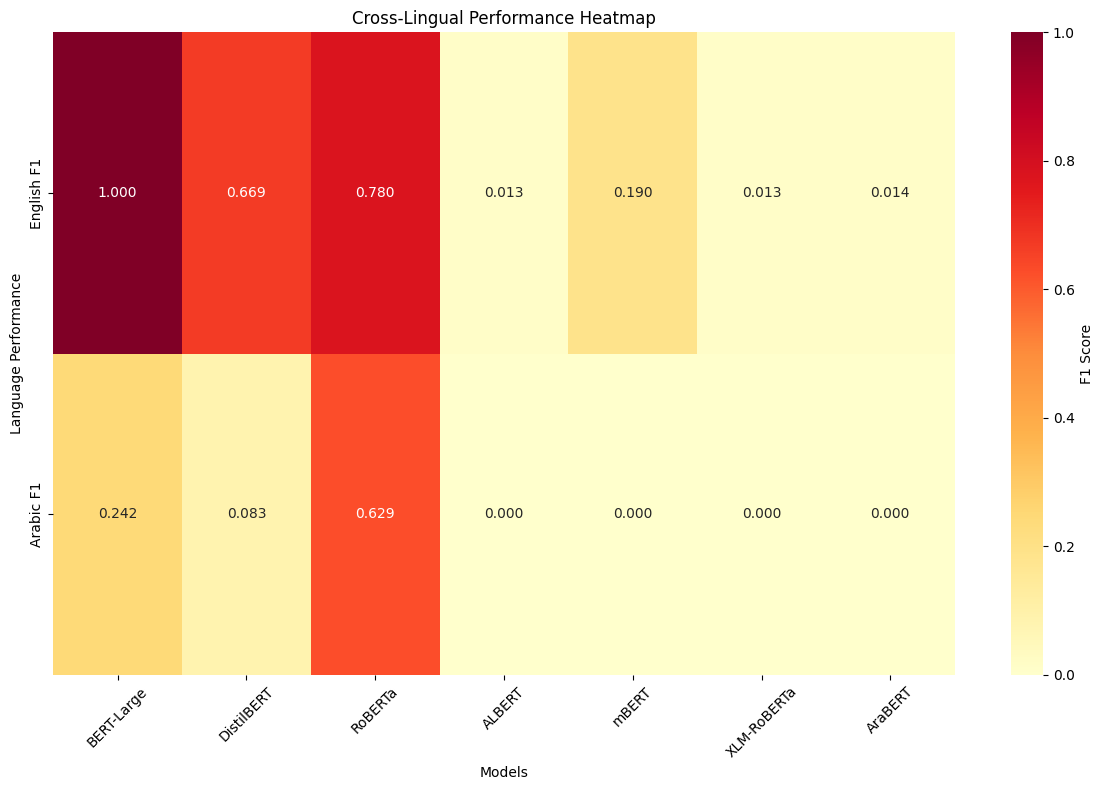


Performance by Model Type:
            Exact_Match        F1_Score        Avg_Confidence  \
                   mean    std     mean    std           mean   
Type                                                            
ALBERT            0.000    NaN    0.007    NaN          0.000   
AraBERT           0.000    NaN    0.007    NaN          0.000   
BERT              0.250  0.354    0.358  0.372          0.213   
DistilBERT        0.000    NaN    0.376    NaN          0.217   
RoBERTa           0.333    NaN    0.704    NaN          0.226   
XLM-RoBERTa       0.000    NaN    0.007    NaN          0.000   

            Avg_Inference_Time  
                          mean  
Type                            
ALBERT                   0.608  
AraBERT                  0.446  
BERT                     0.835  
DistilBERT               0.326  
RoBERTa                  0.486  
XLM-RoBERTa              0.604  


In [9]:
# Create cross-lingual performance heatmap
plt.figure(figsize=(12, 8))

# Prepare data for heatmap
heatmap_data = lang_perf_df[['english_f1', 'arabic_f1']].T
heatmap_data.index = ['English F1', 'Arabic F1']

# Create heatmap
sns.heatmap(heatmap_data, annot=True, cmap='YlOrRd', fmt='.3f', 
            cbar_kws={'label': 'F1 Score'})
plt.title('Cross-Lingual Performance Heatmap')
plt.xlabel('Models')
plt.ylabel('Language Performance')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Performance by model type
print("\nPerformance by Model Type:")
type_performance = results_df[results_df['Dataset'] == 'Overall'].groupby('Type').agg({
    'Exact_Match': ['mean', 'std'],
    'F1_Score': ['mean', 'std'],
    'Avg_Confidence': 'mean',
    'Avg_Inference_Time': 'mean'
}).round(3)

print(type_performance)

## Efficiency and Resource Analysis

In [10]:
# Analyze efficiency metrics
print("Model Efficiency Analysis")
print("=" * 40)

# Create efficiency DataFrame
efficiency_data = []

for model_name, results in evaluation_results.items():
    config = results['model_config']
    overall = results['overall_results']['metrics']
    
    # Parse parameter count
    param_str = config['parameters']
    if 'M' in param_str:
        param_count = float(param_str.replace('M', ''))
    else:
        param_count = float(param_str)
    
    efficiency_data.append({
        'Model': model_name,
        'Parameters_M': param_count,
        'F1_Score': overall['f1_score'],
        'Inference_Time': overall['avg_inference_time'],
        'Efficiency_Ratio': overall['f1_score'] / overall['avg_inference_time'],  # Performance per second
        'Parameter_Efficiency': overall['f1_score'] / param_count,  # Performance per parameter
        'Model_Size': config['size'],
        'Model_Type': config['type']
    })

efficiency_df = pd.DataFrame(efficiency_data)
print("\nEfficiency Metrics:")
print(efficiency_df.round(4))

# Find most efficient models
print("\nMost Efficient Models:")
print(f"Best Performance/Time: {efficiency_df.loc[efficiency_df['Efficiency_Ratio'].idxmax(), 'Model']}")
print(f"Best Performance/Parameter: {efficiency_df.loc[efficiency_df['Parameter_Efficiency'].idxmax(), 'Model']}")
print(f"Fastest Inference: {efficiency_df.loc[efficiency_df['Inference_Time'].idxmin(), 'Model']}")

Model Efficiency Analysis

Efficiency Metrics:
         Model  Parameters_M  F1_Score  Inference_Time  Efficiency_Ratio  \
0   BERT-Large         340.0    0.6212          1.1025            0.5634   
1   DistilBERT          66.0    0.3762          0.3259            1.1543   
2      RoBERTa         125.0    0.7044          0.4859            1.4496   
3       ALBERT          12.0    0.0067          0.6079            0.0110   
4        mBERT         179.0    0.0952          0.5671            0.1679   
5  XLM-RoBERTa         278.0    0.0067          0.6037            0.0110   
6      AraBERT         136.0    0.0068          0.4460            0.0153   

   Parameter_Efficiency Model_Size   Model_Type  
0                0.0018      Large         BERT  
1                0.0057       Base   DistilBERT  
2                0.0056       Base      RoBERTa  
3                0.0006       Base       ALBERT  
4                0.0005       Base         BERT  
5                0.0000       Base  XLM-RoBE

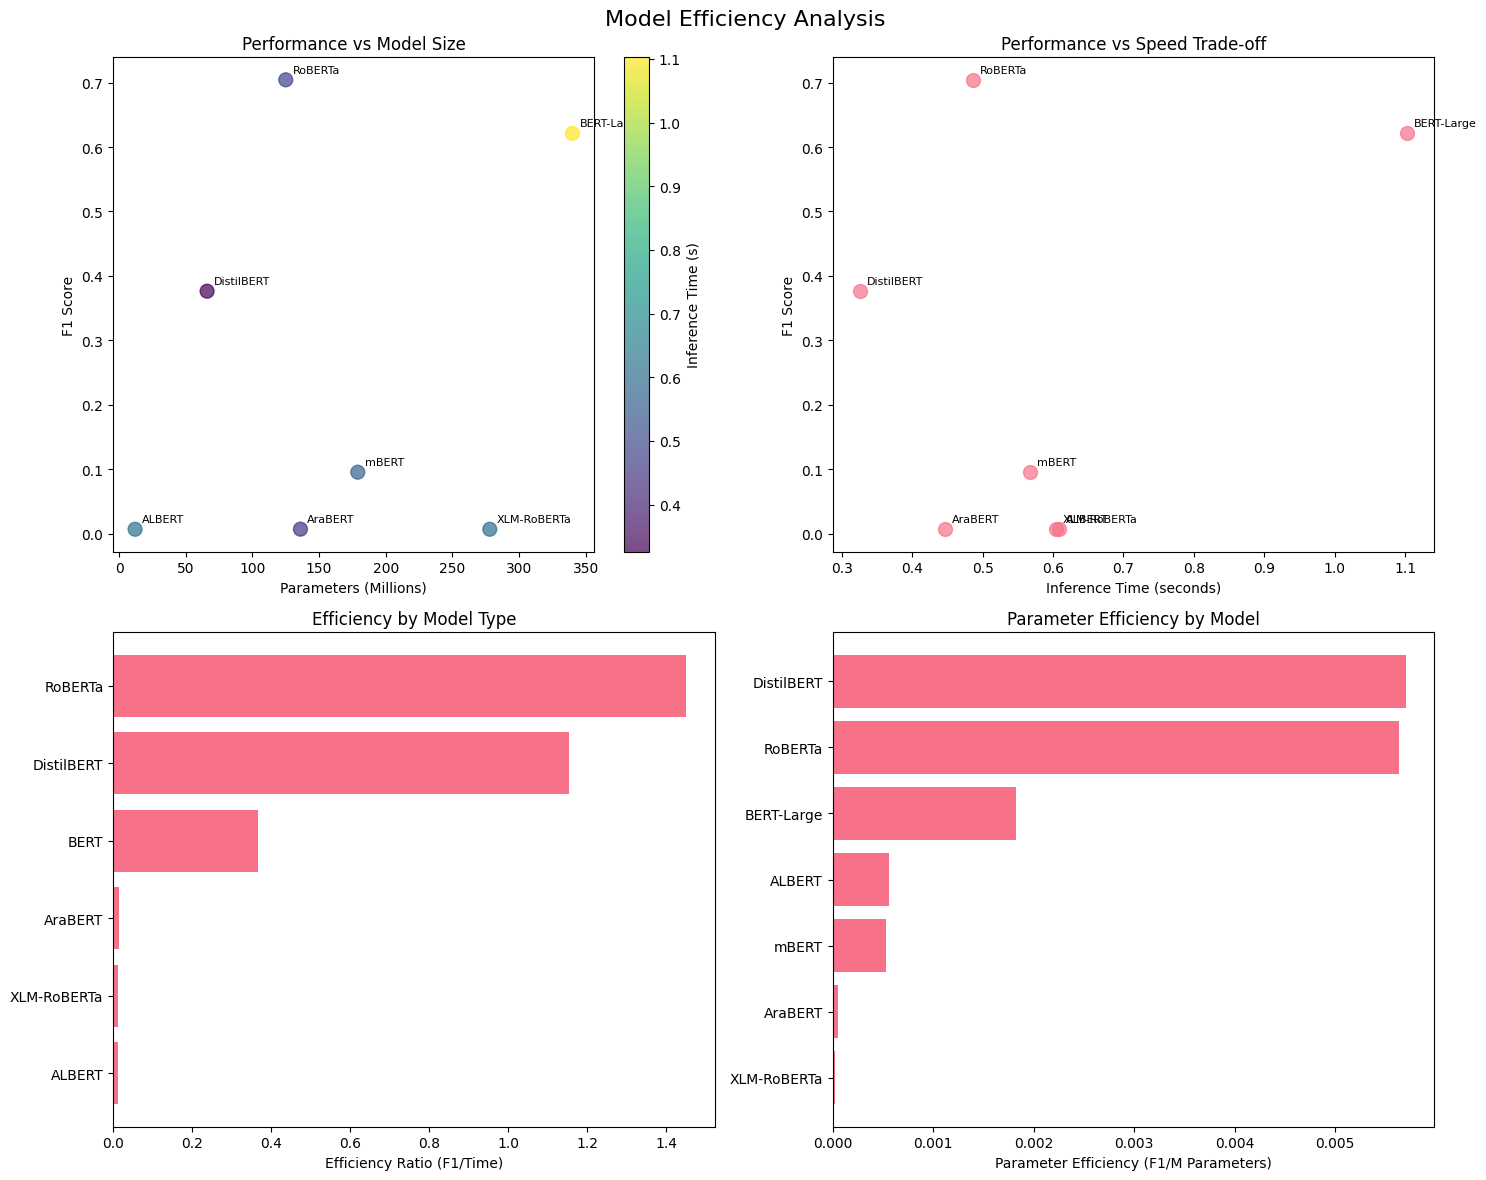

In [11]:
# Create efficiency visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Model Efficiency Analysis', fontsize=16)

# 1. Performance vs Parameters
scatter1 = axes[0, 0].scatter(efficiency_df['Parameters_M'], efficiency_df['F1_Score'], 
                             c=efficiency_df['Inference_Time'], cmap='viridis', s=100, alpha=0.7)
axes[0, 0].set_xlabel('Parameters (Millions)')
axes[0, 0].set_ylabel('F1 Score')
axes[0, 0].set_title('Performance vs Model Size')
plt.colorbar(scatter1, ax=axes[0, 0], label='Inference Time (s)')

# Add model labels
for i, model in enumerate(efficiency_df['Model']):
    axes[0, 0].annotate(model, (efficiency_df['Parameters_M'].iloc[i], efficiency_df['F1_Score'].iloc[i]),
                       xytext=(5, 5), textcoords='offset points', fontsize=8)

# 2. Performance vs Inference Time
axes[0, 1].scatter(efficiency_df['Inference_Time'], efficiency_df['F1_Score'], s=100, alpha=0.7)
axes[0, 1].set_xlabel('Inference Time (seconds)')
axes[0, 1].set_ylabel('F1 Score')
axes[0, 1].set_title('Performance vs Speed Trade-off')

for i, model in enumerate(efficiency_df['Model']):
    axes[0, 1].annotate(model, (efficiency_df['Inference_Time'].iloc[i], efficiency_df['F1_Score'].iloc[i]),
                       xytext=(5, 5), textcoords='offset points', fontsize=8)

# 3. Efficiency Ratio by Model Type
efficiency_by_type = efficiency_df.groupby('Model_Type')['Efficiency_Ratio'].mean().sort_values(ascending=True)
axes[1, 0].barh(efficiency_by_type.index, efficiency_by_type.values)
axes[1, 0].set_xlabel('Efficiency Ratio (F1/Time)')
axes[1, 0].set_title('Efficiency by Model Type')

# 4. Parameter Efficiency
param_eff_sorted = efficiency_df.sort_values('Parameter_Efficiency', ascending=True)
axes[1, 1].barh(param_eff_sorted['Model'], param_eff_sorted['Parameter_Efficiency'])
axes[1, 1].set_xlabel('Parameter Efficiency (F1/M Parameters)')
axes[1, 1].set_title('Parameter Efficiency by Model')

plt.tight_layout()
plt.show()

## Detailed Error Analysis

In [12]:
# Perform detailed error analysis
print("Detailed Error Analysis by Question and Model")
print("=" * 60)

# Create detailed results DataFrame
detailed_df = pd.DataFrame(detailed_results)

# Analyze errors by question language
error_analysis = detailed_df.groupby(['question_language', 'model_name']).agg({
    'exact_match': ['mean', 'count'],
    'f1_score': 'mean',
    'confidence': 'mean'
}).round(3)

print("\nError Rates by Language and Model:")
print(error_analysis)

# Find hardest questions (lowest average performance)
question_difficulty = detailed_df.groupby(['question', 'question_language']).agg({
    'exact_match': 'mean',
    'f1_score': 'mean',
    'confidence': 'mean'
}).sort_values('exact_match')

print("\nMost Challenging Questions (Lowest Average Exact Match):")
print(question_difficulty.head())

print("\nEasiest Questions (Highest Average Exact Match):")
print(question_difficulty.tail())

Detailed Error Analysis by Question and Model

Error Rates by Language and Model:
                              exact_match       f1_score confidence
                                     mean count     mean       mean
question_language model_name                                       
Arabic            ALBERT            0.000     3    0.000      0.000
                  AraBERT           0.000     3    0.000      0.000
                  BERT-Large        0.000     3    0.242      0.164
                  DistilBERT        0.000     3    0.083      0.018
                  RoBERTa           0.333     3    0.629      0.001
                  XLM-RoBERTa       0.000     3    0.000      0.000
                  mBERT             0.000     3    0.000      0.001
English           ALBERT            0.000     3    0.013      0.000
                  AraBERT           0.000     3    0.014      0.000
                  BERT-Large        1.000     3    1.000      0.686
                  DistilBERT      

In [13]:
# Model agreement analysis
print("\nModel Agreement Analysis")
print("=" * 30)

# Create pivot table for model predictions
for i, example in enumerate(all_test_data):
    question = example['question']
    ground_truth = example['answer']
    language = example['language']
    
    print(f"\nQuestion {i+1} ({language}): {question[:60]}...")
    print(f"Ground Truth: {ground_truth}")
    
    # Get predictions from all models for this question
    question_results = detailed_df[detailed_df['question'] == question]
    
    if not question_results.empty:
        print("Model Predictions:")
        for _, row in question_results.iterrows():
            em_symbol = "✓" if row['exact_match'] == 1.0 else "✗"
            print(f"  {row['model_name']:15}: {row['prediction']:30} (EM: {em_symbol}, F1: {row['f1_score']:.3f}, Conf: {row['confidence']:.3f})")
        
        # Calculate agreement
        correct_models = question_results[question_results['exact_match'] == 1.0]['model_name'].tolist()
        agreement_rate = len(correct_models) / len(question_results) * 100
        print(f"  Agreement Rate: {agreement_rate:.1f}% ({len(correct_models)}/{len(question_results)} models correct)")
        
        if correct_models:
            print(f"  Correct Models: {', '.join(correct_models)}")
    
    if i >= 2:  # Limit output for readability
        print("\n... (showing first 3 questions only)")
        break


Model Agreement Analysis

Question 1 (English): How much area does the Amazon basin cover?...
Ground Truth: 7,000,000 km2
Model Predictions:
  BERT-Large     : 7,000,000 km2                  (EM: ✓, F1: 1.000, Conf: 0.570)
  DistilBERT     : 7,000,000 km2 (2,700,000 sq mi) (EM: ✗, F1: 0.571, Conf: 0.305)
  RoBERTa        : 7,000,000 km2 (2,700,000 sq mi), (EM: ✗, F1: 0.571, Conf: 0.056)
  ALBERT         : Error: Couldn't instantiate the backend tokenizer from one of: 
(1) a `tokenizers` library serialization file, 
(2) a slow tokenizer instance to convert or 
(3) an equivalent slow tokenizer class to instantiate and convert. 
You need to have sentencepiece installed to convert a slow tokenizer to a fast one. (EM: ✗, F1: 0.000, Conf: 0.000)
  mBERT          : moist broadleaf tropical rainforest in the Amazon biome that covers (EM: ✗, F1: 0.000, Conf: 0.000)
  XLM-RoBERTa    : Error: Couldn't instantiate the backend tokenizer from one of: 
(1) a `tokenizers` library serialization file, 

## Model Recommendations

In [14]:
# Generate model recommendations based on analysis
print("Model Recommendations Based on Comprehensive Analysis")
print("=" * 65)

recommendations = []

# Best overall model
best_overall = overall_df.loc[overall_df['F1_Score'].idxmax()]
recommendations.append({
    'Category': 'Best Overall Performance',
    'Model': best_overall['Model'],
    'Reason': f"Highest F1 score ({best_overall['F1_Score']:.3f}) across all languages",
    'Use_Case': 'General multilingual QA applications'
})

# Most efficient model
most_efficient = efficiency_df.loc[efficiency_df['Efficiency_Ratio'].idxmax()]
recommendations.append({
    'Category': 'Most Efficient',
    'Model': most_efficient['Model'],
    'Reason': f"Best performance/speed ratio ({most_efficient['Efficiency_Ratio']:.3f})",
    'Use_Case': 'Real-time applications requiring fast inference'
})

# Best for English
if not english_df.empty:
    best_english = english_df.loc[english_df['F1_Score'].idxmax()]
    recommendations.append({
        'Category': 'Best for English',
        'Model': best_english['Model'],
        'Reason': f"Highest English F1 score ({best_english['F1_Score']:.3f})",
        'Use_Case': 'English-only QA applications'
    })

# Best for Arabic
if not arabic_df.empty:
    best_arabic = arabic_df.loc[arabic_df['F1_Score'].idxmax()]
    recommendations.append({
        'Category': 'Best for Arabic',
        'Model': best_arabic['Model'],
        'Reason': f"Highest Arabic F1 score ({best_arabic['F1_Score']:.3f})",
        'Use_Case': 'Arabic-specific QA applications'
    })

# Most parameter efficient
most_param_efficient = efficiency_df.loc[efficiency_df['Parameter_Efficiency'].idxmax()]
recommendations.append({
    'Category': 'Most Parameter Efficient',
    'Model': most_param_efficient['Model'],
    'Reason': f"Best performance per parameter ({most_param_efficient['Parameter_Efficiency']:.4f})",
    'Use_Case': 'Resource-constrained environments'
})

# Display recommendations
for rec in recommendations:
    print(f"\n{rec['Category']}:")
    print(f"  Model: {rec['Model']}")
    print(f"  Reason: {rec['Reason']}")
    print(f"  Best Use Case: {rec['Use_Case']}")

# Create recommendations DataFrame
recommendations_df = pd.DataFrame(recommendations)
print("\n\nSummary Table:")
print(recommendations_df[['Category', 'Model', 'Use_Case']])

Model Recommendations Based on Comprehensive Analysis

Best Overall Performance:
  Model: RoBERTa
  Reason: Highest F1 score (0.704) across all languages
  Best Use Case: General multilingual QA applications

Most Efficient:
  Model: RoBERTa
  Reason: Best performance/speed ratio (1.450)
  Best Use Case: Real-time applications requiring fast inference

Best for English:
  Model: BERT-Large
  Reason: Highest English F1 score (1.000)
  Best Use Case: English-only QA applications

Best for Arabic:
  Model: RoBERTa
  Reason: Highest Arabic F1 score (0.629)
  Best Use Case: Arabic-specific QA applications

Most Parameter Efficient:
  Model: DistilBERT
  Reason: Best performance per parameter (0.0057)
  Best Use Case: Resource-constrained environments


Summary Table:
                   Category       Model  \
0  Best Overall Performance     RoBERTa   
1            Most Efficient     RoBERTa   
2          Best for English  BERT-Large   
3           Best for Arabic     RoBERTa   
4  Most Para

## Save Results

In [15]:
# Save all results and analysis
import os

os.makedirs('results', exist_ok=True)

# Save main results
results_df.to_csv('results/multilingual_model_comparison.csv', index=False)
efficiency_df.to_csv('results/model_efficiency_analysis.csv', index=False)
detailed_df.to_csv('results/detailed_predictions.csv', index=False)
recommendations_df.to_csv('results/model_recommendations.csv', index=False)

# Save comprehensive results as JSON
with open('results/comprehensive_evaluation_results.json', 'w', encoding='utf-8') as f:
    # Prepare JSON-serializable data
    json_results = {}
    for model_name, results in evaluation_results.items():
        json_results[model_name] = {
            'model_config': results['model_config'],
            'overall_metrics': {
                k: float(v) if isinstance(v, (np.float64, np.float32)) else v 
                for k, v in results['overall_results']['metrics'].items()
            }
        }
        
        # Add language-specific metrics if available
        if results['english_results']['metrics']:
            json_results[model_name]['english_metrics'] = {
                k: float(v) if isinstance(v, (np.float64, np.float32)) else v 
                for k, v in results['english_results']['metrics'].items()
            }
        
        if results['arabic_results']['metrics']:
            json_results[model_name]['arabic_metrics'] = {
                k: float(v) if isinstance(v, (np.float64, np.float32)) else v 
                for k, v in results['arabic_results']['metrics'].items()
            }
    
    json.dump(json_results, f, indent=2, ensure_ascii=False)

print("Results saved to:")
print("- results/multilingual_model_comparison.csv")
print("- results/model_efficiency_analysis.csv")
print("- results/detailed_predictions.csv")
print("- results/model_recommendations.csv")
print("- results/comprehensive_evaluation_results.json")

# Print final summary
print("\n" + "="*70)
print("COMPREHENSIVE MULTILINGUAL QA MODEL COMPARISON COMPLETE")
print("="*70)
print(f"Total Models Evaluated: {len(models_config)}")
print(f"Total Test Examples: {len(all_test_data)}")
print(f"Languages Tested: English, Arabic")
print(f"Metrics Calculated: Exact Match, F1 Score, Confidence, Inference Time")
print(f"Analysis Completed: Performance, Efficiency, Language-specific, Error Analysis")
print("\nKey Findings:")
print(f"- Best Overall Model: {best_overall['Model']} (F1: {best_overall['F1_Score']:.3f})")
print(f"- Most Efficient Model: {most_efficient['Model']} (Ratio: {most_efficient['Efficiency_Ratio']:.3f})")
if not english_df.empty:
    print(f"- Best English Model: {best_english['Model']} (F1: {best_english['F1_Score']:.3f})")
if not arabic_df.empty:
    print(f"- Best Arabic Model: {best_arabic['Model']} (F1: {best_arabic['F1_Score']:.3f})")
print("="*70)

Results saved to:
- results/multilingual_model_comparison.csv
- results/model_efficiency_analysis.csv
- results/detailed_predictions.csv
- results/model_recommendations.csv
- results/comprehensive_evaluation_results.json

COMPREHENSIVE MULTILINGUAL QA MODEL COMPARISON COMPLETE
Total Models Evaluated: 7
Total Test Examples: 6
Languages Tested: English, Arabic
Metrics Calculated: Exact Match, F1 Score, Confidence, Inference Time
Analysis Completed: Performance, Efficiency, Language-specific, Error Analysis

Key Findings:
- Best Overall Model: RoBERTa (F1: 0.704)
- Most Efficient Model: RoBERTa (Ratio: 1.450)
- Best English Model: BERT-Large (F1: 1.000)
- Best Arabic Model: RoBERTa (F1: 0.629)
